In [ ]:
!pip install watson-machine-learning-client==1.0.376

!pip install --upgrade ibm-ai-openscale

!pip install pyspark==2.3.0

In [ ]:
from pyspark.sql.functions import col, trim, lower
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()

In [ ]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'endpoint',
    'service_id': 'service_id',
    'iam_service_endpoint': 'endpoint',
    'api_key': 'api_key'
}

configuration_name = 'configname'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_data = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .load(cos.url('dataset.csv', 'lendingclub-donotdelete-pr-102f9pbcpkkuj9'), header=True, inferSchema=True)
df_data.take(5)


In [ ]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_30d96c6e27154b7d92410a8469740ae4 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='api',
    ibm_auth_endpoint="endpoint",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_30d96c6e27154b7d92410a8469740ae4.get_object(Bucket='lendingclub-donotdelete-pr-102f9pbckkuj9',Key='dataset.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

pd_data = pd.read_csv(body)
pd_data.head()


In [ ]:
df_data.printSchema()

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [ ]:
selected_columns = ['application_type','loan_amnt','purpose','annual_inc','fico_range_low','term','dti','revol_bal','revol_util',
           'inq_last_6mths','delinq_2yrs','pub_rec','total_bal_il','total_rev_hi_lim','avg_cur_bal','tot_hi_cred_lim']

In [ ]:
label = ['grade']

In [ ]:
pd_data = pd_data[selected_columns+label]
spark_df = df_data.select(*selected_columns+label)

In [ ]:
def transform_purpose(self, value):
    if value in ['debt_consolidation', 'credit_card','medical', 'house', 'car', 'small_business', 'other']:
        return value
    else:
        return 'personal'

# pd_data['purpose'] = pd_data['purpose'].apply(transform_purpose)

udf_func = udf(transform_purpose, StringType())
spark_df = spark_df.withColumn('purpose', udf_func(col('purpose'), 'purpose'))

In [ ]:
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

spark_df.printSchema()

In [ ]:
cat_cols = list(pd_data.drop('grade', axis=1).select_dtypes('object').columns)
num_cols = list(pd_data.drop('grade', axis=1).select_dtypes('number').columns)

In [ ]:
cat_cols

In [ ]:
num_cols

In [ ]:
dict_cat_SI = {}
cat_cols_IX = []
for col in cat_cols:
    dict_cat_SI[col] = StringIndexer(inputCol = col, outputCol = col+'_IX')
    cat_cols_IX.append(col+'_IX')

In [ ]:
label_SI = StringIndexer(inputCol="grade", outputCol="label").fit(spark_df)
# if got error Pyspark error - Unsupported class file major version 55
# use this solution https://stackoverflow.com/a/58741543/5932828

In [ ]:
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=label_SI.labels)

In [ ]:
features_VA = VectorAssembler(inputCols=cat_cols_IX + num_cols, outputCol="features")

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
clf = RandomForestClassifier(featuresCol="features")

In [ ]:
list(dict_cat_SI.values())

In [ ]:
pipeline = Pipeline(stages=list(dict_cat_SI.values()) + [label_SI, features_VA, clf, label_converter])

In [ ]:
model = pipeline.fit(train_data)

In [ ]:
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="accuracy")


In [ ]:
accuracy_model = evaluator.evaluate(predictions)

In [ ]:
accuracy_model

In [ ]:
# ! pip install --user --upgrade ibm-ai-openscale

# !pip install --user watson_machine_learning_client


In [ ]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *
from ibm_ai_openscale.utils import get_instance_guid
from ibm_ai_openscale.supporting_classes import *
from datetime import datetime

In [ ]:
CLOUD_API_KEY = "cloud_api_key"
WML_CREDENTIALS = {
  "apikey": "apikey",
  "iam_apikey_description": "description",
  "iam_apikey_name": "LendingClubCred",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "serviceid",
  "instance_id": "instanceid",
  "url": "https://us-south.ml.cloud.ibm.com"
}
DB_CREDENTIALS = None
KEEP_MY_INTERNAL_POSTGRES = True
MODEL_NAME = "LendingClub Model - v0.1"
DEPLOYMENT_NAME = "LendingClub Model Deployment - v0.1"


In [ ]:
training_data_reference = {
        "connection": {
          "db": "BLUDB", 
          "host": "host", 
          "password": "password", 
          "username": "username"
        }, 
        "name": "LendingClub Credit Grade Training Data", 
        "source": {
          "tablename": "BXJ33585.LENDINGCLUB", 
          "type": "db2"
        }
      }


In [ ]:
wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)
model_deployment_ids = wml_client.deployments.get_uids()
for deployment_id in model_deployment_ids:
    deployment = wml_client.deployments.get_details(deployment_id)
    model_id = deployment['entity']['deployable_asset']['guid']
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()

In [ ]:
model_props = {
    wml_client.repository.ModelMetaNames.NAME: "{}".format(MODEL_NAME),
    wml_client.repository.ModelMetaNames.EVALUATION_METHOD: "multiclass",
    wml_client.repository.ModelMetaNames.TRAINING_DATA_REFERENCE: training_data_reference,
    wml_client.repository.ModelMetaNames.EVALUATION_METRICS: [
        {
           "name": "accuracy",
           "value": accuracy_model,
           "threshold": 0.8
        }
    ]
}

In [ ]:
## DEPLOYMENT START HERE
# import required lib, train data, pipeline (e2e) and model binary/json here

wml_models = wml_client.repository.get_details()
model_uid = None
for model_in in wml_models['models']['resources']:
    if MODEL_NAME == model_in['entity']['name']:
        model_uid = model_in['metadata']['guid']
        break

if model_uid is None:
    print("Storing model ...")

    published_model_details = wml_client.repository.store_model(model=model, meta_props=model_props, training_data=train_data, pipeline=pipeline)
    model_uid = wml_client.repository.get_model_uid(published_model_details)
    print("Done")
print(model_uid)

In [ ]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break

if deployment_uid is None:
    print("Deploying model...")

    deployment = wml_client.deployments.create(artifact_uid=model_uid, name=DEPLOYMENT_NAME, asynchronous=False)
    deployment_uid = wml_client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

### OPENSCALE MONITORING

In [ ]:
WOS_GUID = get_instance_guid(api_key=CLOUD_API_KEY)
WOS_CREDENTIALS = {
    "instance_guid": WOS_GUID,
    "apikey": CLOUD_API_KEY,
    "url": "https://api.aiopenscale.cloud.ibm.com"
}
# need one instance created fist
if WOS_GUID is None:
    print('Watson OpenScale GUID NOT FOUND')
else:
    print(WOS_GUID)

In [ ]:
ai_client = APIClient(aios_credentials=WOS_CREDENTIALS)
ai_client.version

In [ ]:
try:
    data_mart_details = ai_client.data_mart.get_details()
    if 'internal_database' in data_mart_details and data_mart_details['internal_database']:
        if KEEP_MY_INTERNAL_POSTGRES:
            print('Using existing internal datamart.')
        else:
            if DB_CREDENTIALS is None:
                print('No postgres credentials supplied. Using existing internal datamart')
            else:
                print('Switching to external datamart')
                ai_client.data_mart.delete(force=True)
                ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
    else:
        print('Using existing external datamart')
except:
    if DB_CREDENTIALS is None:
        print('Setting up internal datamart')
        ai_client.data_mart.setup(internal_db=True)
    else:
        print('Setting up external datamart')
        try:
            ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS)
        except:
            print('Setup failed, trying Db2 setup')
            ai_client.data_mart.setup(db_credentials=DB_CREDENTIALS, schema=DB_CREDENTIALS['username'])
    
data_mart_details = ai_client.data_mart.get_details()

In [ ]:
ai_client.data_mart.bindings.list()

In [ ]:
BINDING_NAME = 'LendingClub Model Monitoring'
binding_uid = ai_client.data_mart.bindings.add(BINDING_NAME, WatsonMachineLearningInstance(WML_CREDENTIALS))
bindings_details = ai_client.data_mart.bindings.get_details()

if binding_uid is None:
    binding_uid = [binding['metadata']['guid'] for binding in bindings_details['service_bindings'] if binding['entity']['name']==BINDING_NAME][0]

ai_client.data_mart.bindings.list()

print(binding_uid)

In [ ]:
ai_client.data_mart.bindings.list_assets(binding_uid=binding_uid)

In [ ]:
## START SUBSCRIBE TO BINDED & DEPLOYED MODEL TO OPENSCALE
# define label_column, prediction_column, probability_column, transaction_id_column, feature_columns, categorical_columns

subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = ai_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == MODEL_NAME:
        ai_client.data_mart.subscriptions.delete(subscription)
        print('Deleted existing subscription for', MODEL_NAME)

subscription = ai_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    model_uid,
    problem_type=ProblemType.MULTICLASS_CLASSIFICATION,
    input_data_type=InputDataType.STRUCTURED,
    label_column = "grade",
    prediction_column="predictedLabel",
    feature_columns = cat_cols + num_cols,
    categorical_columns = cat_cols
))

if subscription is None:
    print('Subscription already exists; get the existing one')
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            subscription = ai_client.data_mart.subscriptions.get(sub)

subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
ai_client.data_mart.subscriptions.list()

In [ ]:
subscription_details = subscription.get_details()
print(subscription.uid)
## SUBSCRIPTION END HERE

### SIMULATE PAYLOAD

In [ ]:
pd_data.values[0]

In [ ]:
train_data.head()

In [ ]:
# SIMULATE LOAN APPLICATION CASES TO OUTPUT PAYLOAD IN OPENSCALE

credit_risk_scoring_endpoint = None
print(deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        credit_risk_scoring_endpoint = deployment['entity']['scoring_url']
        
print(credit_risk_scoring_endpoint)

# Enter cases here
values = [
  ['Individual', 24700.0, 'debt_consolidation', 65000.0, 715.0,
       ' 36 months', 16.06, 21470.0, 19.2, 4.0, 1.0, 0.0, 18005.0,
       111800.0, 9733.0, 314017.0]
]
payload_scoring = {"fields": ['application_type', 'loan_amnt', 'purpose', 'annual_inc',
       'fico_range_low', 'term', 'dti', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'total_bal_il',
       'total_rev_hi_lim', 'avg_cur_bal', 'tot_hi_cred_lim'],"values": values}
scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)

print('Single record scoring result:', '\n fields:', scoring_response['fields'], '\n values: ', scoring_response['values'][0])
time.sleep(10)
subscription.payload_logging.get_records_count() #should be the same as the number of cases you passed in

## END SIMULATION

<pre>
Single record scoring result: 
 fields: ['application_type', 'loan_amnt', 'purpose', 'annual_inc', 'fico_range_low', 'term', 'dti', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'total_bal_il', 'total_rev_hi_lim', 'avg_cur_bal', 'tot_hi_cred_lim', 'application_type_IX', 'purpose_IX', 'term_IX', 'label', 'features', 'rawPrediction', 'probability', 'prediction', 'predictedLabel'] 
 values:  ['Individual', 24700.0, 'debt_consolidation', 65000.0, 715.0, ' 36 months', 16.06, 21470.0, 19.2, 4.0, 1.0, 0.0, 18005.0, 111800.0, 9733.0, 314017.0, 0.0, 0.0, 0.0, 0.0, [0.0, 0.0, 0.0, 24700.0, 65000.0, 715.0, 16.06, 21470.0, 19.2, 4.0, 1.0, 0.0, 18005.0, 111800.0, 9733.0, 314017.0], [1.4521063011926765, 0.9556260012305275, 8.635843133604034, 0.9927574942062987, 3.6378887322850395, 2.293064657733285, 2.0327136797481384], [0.07260531505963383, 0.04778130006152638, 0.4317921566802017, 0.04963787471031493, 0.18189443661425198, 0.11465323288666425, 0.10163568398740692], 2.0, 'A']

1
</pre>

### QUALITY MONITORING

In [ ]:
run_details = subscription.quality_monitoring.run(background_mode=False)
time.sleep(10)
subscription.quality_monitoring.show_table()

quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd.plot.barh(x='id', y='value');

### DRIFT AND FAIRNESS MONITORING

In [ ]:
subscription.update(categorical_columns=[])

In [55]:
pd_data

,application_type,loan_amnt,purpose,annual_inc,fico_range_low,term,dti,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,total_bal_il,total_rev_hi_lim,avg_cur_bal,tot_hi_cred_lim,grade
0,Individual,24700.0,small_business,65000.0,715.0,36 months,16.06,21470.0,19.2,4.0,1.0,0.0,18005.0,111800.0,9733.0,314017.0,C
1,Individual,10400.0,major_purchase,104433.0,695.0,60 months,25.37,21929.0,64.5,3.0,1.0,0.0,73839.0,34000.0,27644.0,439570.0,F
2,Individual,7200.0,debt_consolidation,55000.0,680.0,36 months,17.35,5938.0,69.0,0.0,0.0,1.0,269893.0,8600.0,11493.0,255047.0,D
3,Individual,23100.0,car,110000.0,660.0,60 months,20.43,20594.0,94.9,0.0,0.0,0.0,34454.0,21700.0,5505.0,102524.0,E
4,Individual,12000.0,debt_consolidation,53750.0,700.0,36 months,15.30,3172.0,17.2,0.0,1.0,0.0,6468.0,18400.0,17827.0,183062.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28030,Individual,6000.0,credit_card,50000.0,670.0,36 months,21.56,6718.0,62.8,0.0,0.0,0.0,38159.0,10700.0,7480.0,85097.0,B
28031,Individual,12000.0,debt_consolidation,130000.0,675.0,36 months,17.21,24870.0,46.2,0.0,1.0,0.0,53203.0,53800.0,10405.0,275139.0,B
28032,Individual,12600.0,credit_card,30000.0,685.0,36 months,26.89,8181.0,62.5,1.0,0.0,0.0,14288.0,13100.0,1728.0,32866.0,C
28033,Individual,30000.0,home_improvement,275000.0,665.0,60 months,10.99,14000.0,49.1,2.0,0.0,1.0,134130.0,28500.0,47480.0,603362.0,C


In [ ]:
pd_data['purpose'].value_counts()

In [ ]:
feed_data = pd_data.to_dict(orient='split')

In [ ]:
feed_data["fields"] = feed_data.pop("columns")
feed_data["values"] = feed_data.pop("data")
feed_data.pop('index', None)

In [ ]:
import json
with open('lending_club_feed.json', 'w') as f:
    json.dump(feed_data, f)

In [ ]:
## MUST ENABLE DRIFT BEFORE FAIRNESS
## define what factor is likely to be jeopardise due to data amt (e.g. purpose), favorable class is grade A, and not favorable is grade G (lowest)

subscription.fairness_monitoring.enable(
            features=[
                Feature("purpose", majority=['debt_consolidation','credit_card'], 
                        minority=['house', 'medical', 'car'], threshold=0.95)
            ],
            favourable_classes=['A'],
            unfavourable_classes=['G'],
            min_records=10,
            training_data=pd_data
        )



In [ ]:
fields = feed_data['fields']
values = []
for _ in range(1000):
    values.append(random.choice(feed_data['values']))
payload_scoring = {"fields": fields, "values": values}

scoring_response = wml_client.deployments.score(credit_risk_scoring_endpoint, payload_scoring)
print(scoring_response)

In [ ]:
subscription.get_details()

In [80]:


fairness_run_details = subscription.fairness_monitoring.run(background_mode=False)
time.sleep(10)

subscription.fairness_monitoring.show_table()





 Counting bias for deployment_uid=ea52c01f-ffc0-4dbb-8288-f89dbe01a7fa 




RUNNING.
FINISHED

---------------------------
 Successfully finished run 
---------------------------




2020-05-03 14:37:53.079986+00:00,purpose,house,False,1.0,28.57142857142857,d0fe90a7-a552-436d-b16b-4d02053854cc,376e6afa-26df-44e9-a0ba-c9ef2628e58a,376e6afa-26df-44e9-a0ba-c9ef2628e58a,ea52c01f-ffc0-4dbb-8288-f89dbe01a7fa,
2020-05-03 14:37:53.079986+00:00,purpose,medical,False,1.0,28.57142857142857,d0fe90a7-a552-436d-b16b-4d02053854cc,376e6afa-26df-44e9-a0ba-c9ef2628e58a,376e6afa-26df-44e9-a0ba-c9ef2628e58a,ea52c01f-ffc0-4dbb-8288-f89dbe01a7fa,
2020-05-03 14:37:53.079986+00:00,purpose,car,False,1.0,22.22222222222222,d0fe90a7-a552-436d-b16b-4d02053854cc,376e6afa-26df-44e9-a0ba-c9ef2628e58a,376e6afa-26df-44e9-a0ba-c9ef2628e58a,ea52c01f-ffc0-4dbb-8288-f89dbe01a7fa,


In [ ]:
# subscription.drift_monitoring.enable(threshold=0.05, min_records=10)
# drift_status = None
# while drift_status != 'finished':
#     drift_details = subscription.drift_monitoring.get_details()
#     drift_status = drift_details['parameters']['config_status']['state']
#     if drift_status != 'finished':
#         print(datetime.utcnow().strftime('%H:%M:%S'), drift_status)
#         time.sleep(30)
# print(drift_status)


# drift_run_details = subscription.drift_monitoring.run(background_mode=False)
# subscription.drift_monitoring.get_table_content()
# # END DRIFT AND FAIRNESS

### EXPLAINABILITY

In [ ]:
subscription.explainability.enable(training_data=pd_data)
explainability_details = subscription.explainability.get_details()

transaction_id = subscription.payload_logging.get_table_content(limit=1)['scoring_id'].values[0]

print(transaction_id)

In [ ]:
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False, cem=False)

In [ ]:
explainability_details

### PERFORMANCE MONITORING (DESPITE OF ACCURACY)

In [ ]:
# Define metrics and grouping(tags) need to be monitored

monitor_name = 'LendingClub Performance Monitoring'
metrics = [Metric(name='sensitivity', lower_limit_default=0.8), Metric(name='specificity', lower_limit_default=0.75)]
tags = [Tag(name='purpose', description='borrower loan purpose')]

def get_definition(monitor_name):
    monitors_definitions = ai_client.data_mart.monitors.get_details()['monitor_definitions']
    
    for definition in monitors_definitions:
        if monitor_name == definition['entity']['name']:
            return definition
    
    return None

existing_definition = get_definition(monitor_name)

if existing_definition is None:
    my_monitor = ai_client.data_mart.monitors.add(name=monitor_name, metrics=metrics, tags=tags)
else:
    my_monitor = existing_definition
    
monitor_uid = my_monitor['metadata']['guid']

print(monitor_uid)

In [ ]:
my_monitor = ai_client.data_mart.monitors.get_details(monitor_uid=monitor_uid)
print('monitor definition details', my_monitor)

In [ ]:
thresholds = [Threshold(metric_uid='sensitivity', lower_limit=0.9)] # change and enable sensitivity see whether reflected in dashboard?
subscription.monitoring.enable(monitor_uid=monitor_uid, thresholds=thresholds)
subscription.monitoring.get_details(monitor_uid=monitor_uid)

In [89]:
# Inspect the tagged group
metrics = {"specificity": 0.78, "sensitivity": 0.67, "purpose": "vacation"}

subscription.monitoring.store_metrics(monitor_uid=monitor_uid, metrics=metrics)

time.sleep(5)

subscription.monitoring.show_table(monitor_uid=monitor_uid)

2020-05-03 14:42:01.391435+00:00,sensitivity,93e5fc0c-8e92-4a54-8c33-db2a2cb615d4,0.67,0.9,,purpose: vacation,d0fe90a7-a552-436d-b16b-4d02053854cc,376e6afa-26df-44e9-a0ba-c9ef2628e58a,ea52c01f-ffc0-4dbb-8288-f89dbe01a7fa
2020-05-03 14:42:01.391435+00:00,specificity,93e5fc0c-8e92-4a54-8c33-db2a2cb615d4,0.78,,,purpose: vacation,d0fe90a7-a552-436d-b16b-4d02053854cc,376e6afa-26df-44e9-a0ba-c9ef2628e58a,ea52c01f-ffc0-4dbb-8288-f89dbe01a7fa


In [ ]:
custom_metrics = subscription.monitoring.get_metrics(monitor_uid=monitor_uid, deployment_uid='credit')
custom_metrics

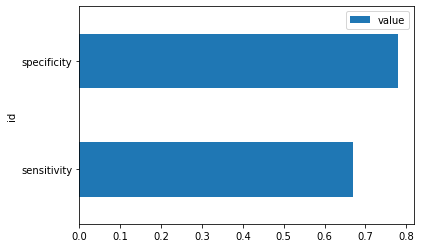

In [91]:
custom_metrics_pandas = subscription.monitoring.get_table_content(monitor_uid=monitor_uid)
custom_metrics_pandas.plot.barh(x='id', y='value');

### BUSINESS METRICS

In [ ]:
business_payload_fields = [
                {
                    "name": "term",
                    "type": "number",
                    "description": "Duration of the loan"
                },
                {
                    "name": "purpose",
                    "type": "string",
                    "description": "Purpose of the loan"
                },
                {
                    "name": "loan_amnt",
                    "type": "number",
                    "description": "Amount of the loan"
                },
                {
                    "name": "int_rate",
                    "type": "number",
                    "description": "Interest rate"
                },
                {
                    "name": "grade",
                    "type": "string",
                    "description": "Credit grade"
                }
    
            ]
business_metrics = [BusinessMetric(metric_name='Credit Grade', description="Daily Credit Grade Count",
                                           field_name='grade', aggregation=AggregationMethods.MAX,# cannot count here
                                   time_unit='day', time_count=1, lower_limit=150),
                    BusinessMetric(metric_name='Loan Amount Applied', description="Daily Total Credit Amount Applied",
                                   field_name='loan_amnt', aggregation=AggregationMethods.SUM,
                                   time_unit='day', time_count=1, lower_limit=500000)]
application_details = ai_client.data_mart.applications.add(name="LendingClub Business Metrics",
                                                           description="LendingClub Business Metrics Monitoring",
                                                           subscription_ids=[subscription.uid],
                                                           business_metrics=business_metrics,
                                                           payload_schema=business_payload_fields)
application_id = application_details['metadata']['id']
while application_details['entity']['status']['state'] == 'preparing':
    print(datetime.utcnow().strftime('%H:%M:%S'), application_details['entity']['status']['state'] )
    time.sleep(10)
    application_details = ai_client.data_mart.applications.get_details(application_id)
print("Final application status: {}".format(application_details['entity']['status']['state']) )
run_details = ai_client.data_mart.applications.run(application_id)